In [1]:
import h5py
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import pathlib
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_size=128
batch_size=1

In [2]:
def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
        nn.BatchNorm2d(out_channels), 
        nn.LeakyReLU(0.2, inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
    
class Upsample(nn.Module):
    def __init__(self, Input_Channels, Output_Channels,stride=2, padding=1,droup=False):
        super(Upsample, self).__init__()
        self.modules = []
        self.modules.append(nn.ConvTranspose2d(Input_Channels, Output_Channels, kernel_size=4, stride=stride, padding=padding, bias=False))
        self.modules.append(nn.BatchNorm2d(Output_Channels))
        if droup:
            self.modules.append(nn.Dropout(0.5))
        self.modules.append(nn.LeakyReLU(0.2, inplace=True))
        self.model=nn.Sequential(*self.modules)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x    



class Generator128(nn.Module):
	def __init__(self, ngpu):
		super(Generator128, self).__init__()
		self.conv1=nn.Sequential(nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
                                nn.LeakyReLU(0.2, inplace=True),
                                )#64*64

		self.conv2=nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(128),#16*16
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1)
                                )#32*32
		self.conv3=nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
                                nn.BatchNorm2d(256),
                                nn.LeakyReLU(0.2, inplace=True),
                                nn.Dropout(0.1)
                                )#16
        
		self.conv4=nn.Sequential(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1)
                                )#8
		self.conv4_=nn.Sequential(nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1)
                                )#4*4        
		self.conv5=nn.Sequential(nn.Conv2d(512, 512, kernel_size=4, stride=1, padding=0, bias=False)
                                )#1
        
		self.convT1 =Upsample(512,512,droup=True, padding=0)#4*4
		self.convT2_ = Upsample(512*2,512,droup=True)#8*8
		self.convT2 = Upsample(512*2,256,droup=True)#1*16*16
        
		self.resT1 = nn.Sequential(conv_block(256*2, 256*2), conv_block(256*2, 256*2))
        
		self.convT3 =Upsample(256*2,128)#1*32*32
		self.convT4 =Upsample(128*2,64)#1*64*64
		self.resT2 = nn.Sequential(conv_block(64*2, 64*2), conv_block(64*2, 64*2))
		self.convT5=nn.Sequential(  nn.ConvTranspose2d(64*2, 1, kernel_size=4, stride=2, padding=1, bias=False))


	def forward(self, input):
		out1 = self.conv1(input)
		out2 = self.conv2(out1)
		out3 = self.conv3(out2)
		out4 = self.conv4(out3)
		out4_ = self.conv4_(out4)
		out5 = self.conv5(out4_)  
       
		outT1 = self.convT1(out5,out4_)
		outT2_ = self.convT2_(outT1,out4)
		outT2 = self.convT2(outT2_,out3)
		outT3 = self.resT1(outT2) + outT2#############
		outT4 = self.convT3(outT3,out2)
		outT5 = self.convT4(outT4,out1)
		outT6 = self.resT2(outT5) + outT5###########
		outT7 = self.convT5(outT6)
		return outT7



genPix2Pix=Generator128(0)
genPLM=Generator128(0)
s=154200
i=200
genPix2Pix.load_state_dict(torch.load(f"E:/PLM-GAN A Large-Scale Protein Loop Modeling Using/Network_Weights/Pix2Pix/pix2pix_{s}_epoch_{i}.pth",map_location="cpu")["gen"])
genPLM.load_state_dict(torch.load(f"E:/PLM-GAN A Large-Scale Protein Loop Modeling Using/Network_Weights/PLM_GAN/pix2pix_{s}_epoch_{i}.pth",map_location="cpu")["gen"])


<All keys matched successfully>

# Read Distance matrix of protein structure
### Natural of distaance matix of 3fjb protein structure
### inpainted of distance matix by RFDesign

In [3]:
import numpy as np
input = np.loadtxt("E:/RFDesign/inpainting/tests/worked/3fjb/3fjb_N.txt", dtype='float32', delimiter=' ')
RFD = np.loadtxt("E:/RFDesign/inpainting/tests/worked/3fjb/3fjb_RFD_S35.txt", dtype='float32', delimiter=' ')


<AxesSubplot:>

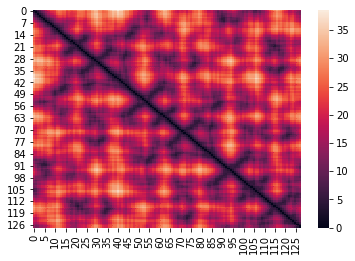

In [4]:
import seaborn as sns
sns.heatmap(input)


# 25 aa missing region added to distance matrix of protein from 35 to 60 aa.

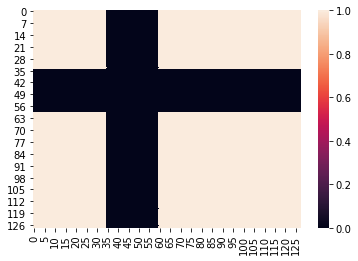

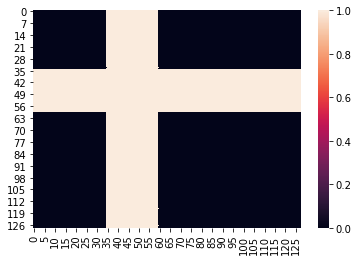

<AxesSubplot:>

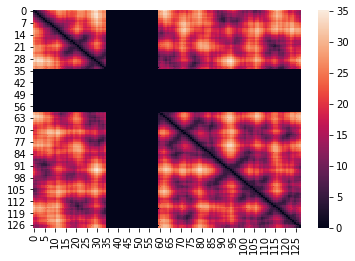

In [5]:
batch_size=1
image_size=128
device="cpu"
noiseArrT = torch.ones(size=(batch_size,1,image_size, image_size)).to(device,dtype=torch.float32)


im=35
maskSize=25
for a in noiseArrT :
    a[0][im:im+ maskSize,:]=0
    a[0][:,im:im+maskSize]=0
    #plt.imshow(a)
sns.heatmap(noiseArrT.reshape(128,128).detach().numpy() )
plt.show()
comp_noiseArrT=(noiseArrT*-1)+1  #with misssing region
sns.heatmap(comp_noiseArrT.reshape(128,128).detach().numpy() )
plt.show()
data=a[0]*input #with misssing region
sns.heatmap(data.reshape(128,128).detach().numpy() )



*********************************pix2pix GAN*******************************************


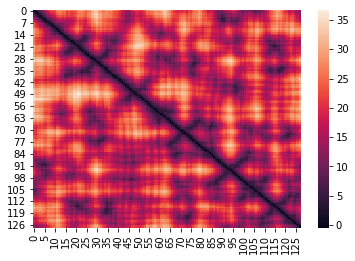

*********************************PLM-GAN*******************************************


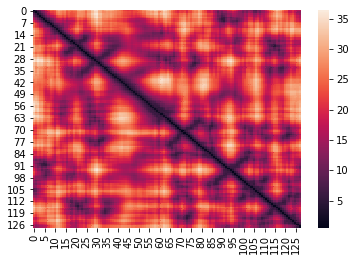

In [8]:

g_genPix2Pix=genPix2Pix(data.reshape(1,1,128,128))
g_genPLM=genPLM(data.reshape(1,1,128,128))
print("*********************************pix2pix GAN*******************************************")
sns.heatmap(g_genPix2Pix.reshape(128,128).detach().numpy() )
plt.show()
print("*********************************PLM-GAN*******************************************")

sns.heatmap(g_genPLM.reshape(128,128).detach().numpy() )
plt.show()


*********************************pix2pix GAN*******************************************


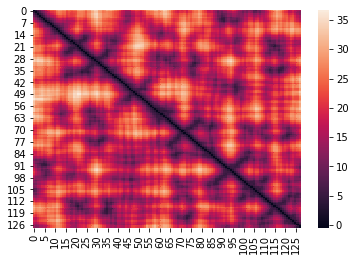

*********************************PLM-GAN*******************************************


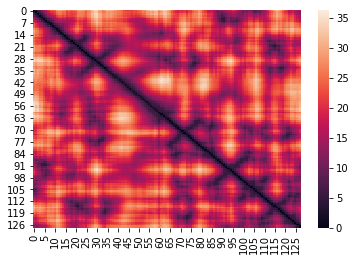

In [12]:

inpainted_genPix2Pix=data+comp_noiseArrT.detach().numpy().reshape(128,128)*g_genPix2Pix.detach().numpy().reshape(128,128)
inpainted_genPLM=   data+comp_noiseArrT.detach().numpy().reshape(128,128)*    g_genPLM.detach().numpy().reshape(128,128)
print("*********************************pix2pix GAN*******************************************")

sns.heatmap(inpainted_genPix2Pix.reshape(128,128).detach().numpy() )
plt.show()
print("*********************************PLM-GAN*******************************************")

sns.heatmap(inpainted_genPLM.reshape(128,128).detach().numpy() )
plt.show()


# Function to calculate the characteristic of the protein's structure distance matrix.
## BackBone on natural protein 3.78A
## Short on natural protein 7.5A
## Long on natural protein 20.31A

In [13]:
image_size=128

def ckeckBackBone(fake_images,image_size=image_size,batch_size=13):#4
    #BackBone
    sum=0
    avgBatch=0
    batch=batch_size
    for b in range(batch):
        for i in range(image_size):
            for j in range(i+1,image_size):
                sum+=fake_images[b][0][i][j]
                break
        avgPeptiedBond=(sum/image_size)
        sum=0
        #print("avg peptide bond protien",b," : " ,avgPeptiedBond)
        avgBatch+=avgPeptiedBond
    #print("avg peptide bond BackBone protien for batch" ,(avgBatch/batch))
    return (avgBatch/batch)
    


def ckeckshort(fake_images,image_size=image_size,batch_size=13):#10
    #short
    avgBatch=0
    batch=batch_size
    imgSize_4=(image_size-4)
    for b in range(batch):
        sum=0
        for i in range(image_size):
            for j in range(i,imgSize_4,4):
                #print("distance(",i,",",j,") :",s)
                sum+=(fake_images[b][0][i][j+2]+fake_images[b][0][i][j+3]+fake_images[b][0][i][j+4])/3
                break
        avgPeptiedBond=(sum/imgSize_4)
        #print("avg peptide bond protien",b," : " ,avgPeptiedBond)
        avgBatch+=avgPeptiedBond
    #print("avg peptide bond short protien for batch" ,(avgBatch/batch))
    return (avgBatch/batch)


    
def ckeckLong(fake_images,image_size=image_size,batch_size=13):#20
    #Long
    batch=batch_size
    bsum=0
    c=0
    for b in range(batch):
        msum=0
        for i in range(image_size-5):
            sum=0
            for j in range(i+5,(image_size)):
                sum+=fake_images[b][0][i][j]
            sum/=(j+1-(i+5))
            msum+=sum
        bsum+=(msum/image_size)
    #print("avg peptide bond Long protien for batch" ,(bsum/batch))
    return (bsum/batch)


def show_image(fake_images,index=0,image_size=image_size):
    import seaborn as sns
    sns.heatmap((fake_images[index].view(image_size,image_size).detach().numpy()))


image_size=128


In [14]:
print("*********************************RFD*******************************************")
print("BackBone: ",ckeckBackBone(RFD.reshape(1,1,128,128),image_size=image_size,batch_size=1))
print("short   : ",ckeckshort(RFD.reshape(1,1,128,128),image_size=image_size,batch_size=1))
print("Long    : ",ckeckLong(RFD.reshape(1,1,128,128),image_size=image_size,batch_size=1))
print("RMSD    : ",torch.sqrt(torch.sum(torch.pow( torch.tensor(RFD.reshape(128,128))-torch.tensor(input.reshape(128,128)) ,2))/(128*128)))

*********************************RFD*******************************************
BackBone:  3.6507600881159306
short   :  8.302715883460092
Long    :  16.271019203301808
RMSD    :  tensor(5.8868)


In [15]:
print("*********************************pix2pix GAN*******************************************")
print("***************************generated************************************")
print("BackBone  : ",ckeckBackBone(g_genPix2Pix,image_size=image_size,batch_size=1))
print("short     : ",ckeckshort(g_genPix2Pix,image_size=image_size,batch_size=1))
print("Long      : ",ckeckLong(g_genPix2Pix,image_size=image_size,batch_size=1))
print("RMSD_generated    : ",torch.sqrt(torch.sum(torch.pow( torch.tensor(g_genPix2Pix.reshape(128,128))-torch.tensor(input.reshape(128,128)) ,2))/(128*128)))
print("***************************inpainted************************************")
print("BackBone  : ",ckeckBackBone(inpainted_genPix2Pix.reshape(1,1,128,128),image_size=image_size,batch_size=1))
print("short     : ",ckeckshort(inpainted_genPix2Pix.reshape(1,1,128,128),image_size=image_size,batch_size=1))
print("Long      : ",ckeckLong(inpainted_genPix2Pix.reshape(1,1,128,128),image_size=image_size,batch_size=1))
print("RMSD_inpainted  : ",torch.sqrt(torch.sum(torch.pow( torch.tensor(inpainted_genPix2Pix.reshape(128,128))-torch.tensor(input.reshape(128,128)) ,2))/(128*128)))

*********************************pix2pix GAN*******************************************
***************************generated************************************
BackBone  :  tensor(3.9349, grad_fn=<DivBackward0>)
short     :  tensor(8.3513, grad_fn=<DivBackward0>)
Long      :  tensor(16.8044, grad_fn=<DivBackward0>)
RMSD_generated    :  tensor(4.6171)
***************************inpainted************************************
BackBone  :  tensor(3.8296)
short     :  tensor(8.3168)
Long      :  tensor(16.7704)
RMSD_inpainted  :  tensor(4.6152)


In [16]:
print("***************************PLM-GAN*******************************************")
print("***************************generated************************************")

print("BackBone  : ",ckeckBackBone(g_genPLM,image_size=image_size,batch_size=1))
print("short     : ",ckeckshort(g_genPLM,image_size=image_size,batch_size=1))
print("Long      : ",ckeckLong(g_genPLM,image_size=image_size,batch_size=1))
print("RMSD_generated  : ",torch.sqrt(torch.sum(torch.pow( torch.tensor(g_genPLM.reshape(128,128))-torch.tensor(input.reshape(128,128)) ,2))/(128*128)))
print("***************************inpainted************************************")
print("BackBone  : ",ckeckBackBone(inpainted_genPLM.reshape(1,1,128,128),image_size=image_size,batch_size=1))
print("short     : ",ckeckshort(inpainted_genPLM.reshape(1,1,128,128),image_size=image_size,batch_size=1))
print("Long      : ",ckeckLong(inpainted_genPLM.reshape(1,1,128,128),image_size=image_size,batch_size=1))
print("RMSD_inpainted  : ",torch.sqrt(torch.sum(torch.pow( torch.tensor(inpainted_genPLM.reshape(128,128))-torch.tensor(input.reshape(128,128)) ,2))/(128*128)))

***************************PLM-GAN*******************************************
***************************generated************************************
BackBone  :  tensor(4.7351, grad_fn=<DivBackward0>)
short     :  tensor(9.0777, grad_fn=<DivBackward0>)
Long      :  tensor(17.7569, grad_fn=<DivBackward0>)
RMSD_generated  :  tensor(4.2214)
***************************inpainted************************************
BackBone  :  tensor(3.9372)
short     :  tensor(8.3023)
Long      :  tensor(17.0263)
RMSD_inpainted  :  tensor(4.1318)


In [17]:
np.savetxt('E:/PLM-GAN A Large-Scale Protein Loop Modeling Using/models/3fjb_p2p_gen_200E_4.6171.txt', inpainted_genPix2Pix.reshape(128,128).to("cpu").detach().numpy())
np.savetxt('E:/PLM-GAN A Large-Scale Protein Loop Modeling Using/models/3fjb_p2p_inp_200E_4.6152.txt', g_genPix2Pix.reshape(128,128).to("cpu").detach().numpy())

In [18]:
np.savetxt('E:/PLM-GAN A Large-Scale Protein Loop Modeling Using/models/3fjb_PLM_gen_200E_4.2214.txt', inpainted_genPLM.reshape(128,128).to("cpu").detach().numpy())
np.savetxt('E:/PLM-GAN A Large-Scale Protein Loop Modeling Using/models/3fjb_PLM_inp_200E_4.1318.txt', g_genPLM.reshape(128,128).to("cpu").detach().numpy())

# Folding Protein
### Folding protein has been using MMD to folding the distance matrix we using the R code

### Save the matrix in text file


#install.packages("Bio2mds")
library(bios2mds)

#install.packages("xlsx")
library(ADMM)
library(bio3d) 


MatR <- scan('E:/RFDesign/inpainting/tests/worked/3fjb/3fjb_N.txt')

MatR=matrix(MatR,ncol = 128, byrow = TRUE)

MatR[lower.tri(MatR)]=t(MatR)[lower.tri(MatR)]

nat=mmds(active=MatR, pc=3, group.file = NULL)


MatR <- scan('E:/PLM-GAN A Large-Scale Protein Loop Modeling Using/models/3fjb_PLM_inp_200E_4.1318.txt')

MatR=matrix(MatR,ncol = 128, byrow = TRUE)

MatR[lower.tri(MatR)]=t(MatR)[lower.tri(MatR)]

PLM=mmds(active=MatR, pc=3, group.file = NULL)


constantFactor=30

mean(sqrt(apply((PLM$coord-nat$coord)^2, 1, sum)))/constantForDistance



write.pdb( xyz = (matrix(unlist(PLM$coord[0:3]), ncol = 3, nrow = 128)/constantForDistance) , file="3fjb_PLM_inp_D30_RMDS3d.pdb" )



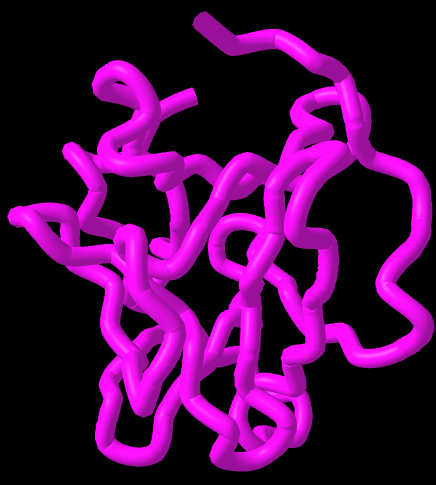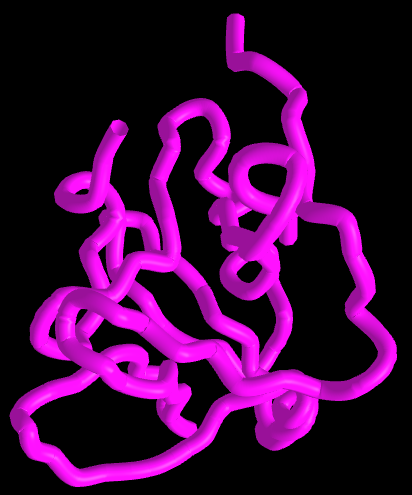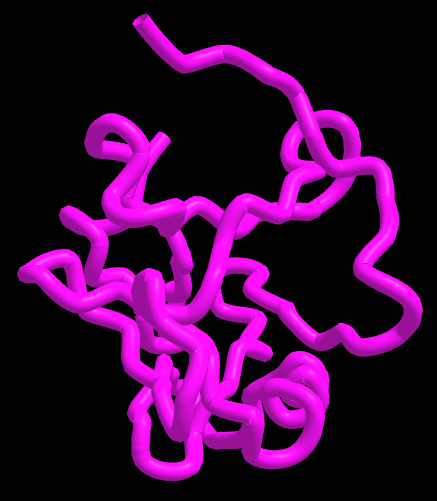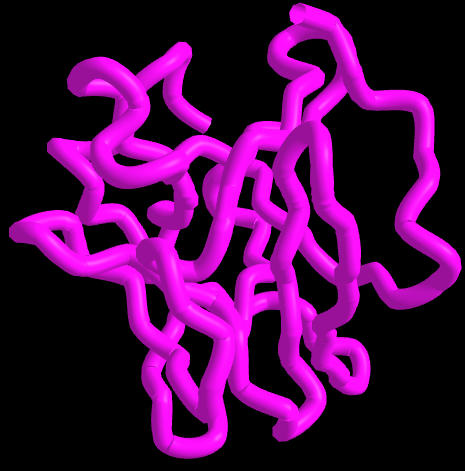